In [ ]:
!pip install statmodels --upgrade

ERROR: Could not find a version that satisfies the requirement statmodels (from versions: none)
ERROR: No matching distribution found for statmodels


In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
year = "2021"  # Example year
months = ["01", "02", "03", "04", "05", "06","07", "08","09", "10", "11","12"]  # Example months

# List to store individual DataFrames
df_list = []

# Iterate over each month and read the corresponding file
for month in months:
    file_path = "/content/drive/MyDrive/MLProjectFiles/2021/"+year+"-"+ month +".csv"
    df_ = pd.read_csv(file_path)
    df_list.append(df_)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Display the combined DataFrame
print(combined_df.head())

print(combined_df.shape)


         date  1  2  3   4  5  6   7  8  9  ...  256  257  258  259  260  261  \
0  2021-01-01  0  0  1  27  0  0  32  2  0  ...    8    0    0    2   12   94   
1  2021-01-02  0  0  0  24  0  0  40  0  0  ...    1    0    0    0   11  132   
2  2021-01-03  0  0  0  16  0  0  24  0  0  ...    2    0    0    0    8   72   
3  2021-01-04  0  0  1  23  0  0  43  1  0  ...    9    0    1    0   12   87   
4  2021-01-05  0  0  1  22  0  0  41  0  0  ...    3    1    1    0    9  101   

   262   263  264  265  
0  285   672  213    7  
1  448   915  251    7  
2  323   656  184    4  
3  703  1076  297   11  
4  789  1110  292    6  

[5 rows x 266 columns]
(365, 266)


In [ ]:
# select the region and date columns
pu_location = '48'

selected_columns = ['date', pu_location]

# convert to date time object.
df = combined_df[selected_columns]
df.loc[:, 'date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


print("Size of the dataset:",df.shape)

df.head()

Size of the dataset: (365, 1)


,48
date,
2021-01-01,859
2021-01-02,883
2021-01-03,646
2021-01-04,978
2021-01-05,1054


<Axes: xlabel='date'>

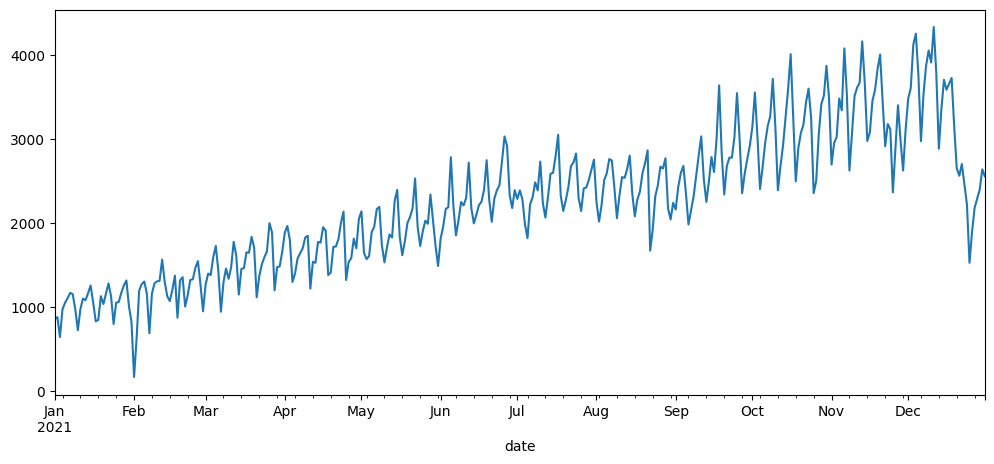

In [ ]:
df[pu_location].plot(figsize=(12,5))


**- For apply that plot should not be stationary. **

+ Mean constant.
+ No seasonality
+ Constant varience - fluctuate by constant amount.

In [ ]:
# y = a1 *  y1 +  a2 * y2  + .... + b
# Check

#  Augmented Dickey-Fuller (ADF)
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df[pu_location], autolag='AIC')

print("1. ADF:", dftest[0])
print("2. P-Value:", dftest[1])
print("3. Num Of Lags:", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation:", dftest[3])
print("5. Critical Values:")
for key, val in dftest[4].items():
    print("\t", key, ": ", val)



1. ADF: -1.6185728454804555
2. P-Value: 0.47347757938535645
3. Num Of Lags: 14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 350
5. Critical Values:
	 1% :  -3.4491725955218655
	 5% :  -2.8698334971428574
	 10% :  -2.5711883591836733


In [ ]:
df.loc[:, 'sd_1']=df[pu_location]-df[pu_location].shift(1)  # row with higher number  -  row with lower number
df.head()


<ipython-input-8-fb8945819257>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'sd_1']=df[pu_location]-df[pu_location].shift(1)  # row with higher number  -  row with lower number


,48,sd_1
date,,
2021-01-01,859,NaN
2021-01-02,883,24.0
2021-01-03,646,-237.0
2021-01-04,978,332.0
2021-01-05,1054,76.0


In [ ]:
df = df.dropna(subset=['sd_1'])
df.head()

,48,sd_1
date,,
2021-01-02,883,24.0
2021-01-03,646,-237.0
2021-01-04,978,332.0
2021-01-05,1054,76.0
2021-01-06,1109,55.0


In [ ]:
dftest = adfuller(df['sd_1'], autolag='AIC')

print("1. ADF:", dftest[0])
print("2. P-Value:", dftest[1])
print("3. Num Of Lags:", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation:", dftest[3])
print("5. Critical Values:")
for key, val in dftest[4].items():
    print("\t", key, ": ", val)

1. ADF: -5.8081938652637755
2. P-Value: 4.4650299352707264e-07
3. Num Of Lags: 13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 350
5. Critical Values:
	 1% :  -3.4491725955218655
	 5% :  -2.8698334971428574
	 10% :  -2.5711883591836733


Since now its is stationary we can apply the auto regression

<Axes: xlabel='date'>

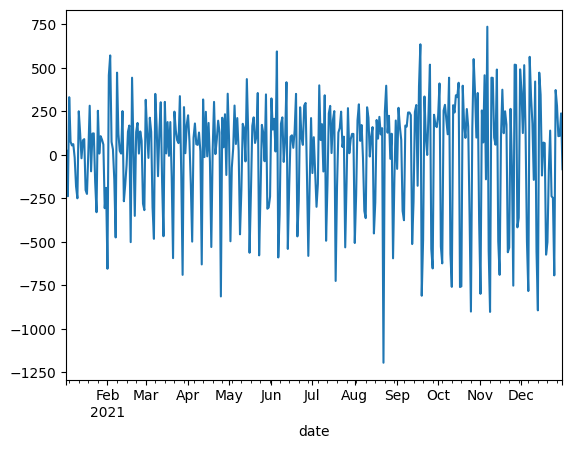

In [ ]:
df.head()
df['sd_1'].plot()

# look now its stationary.

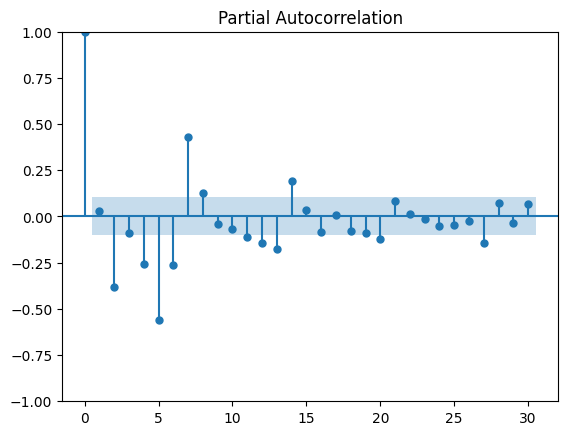

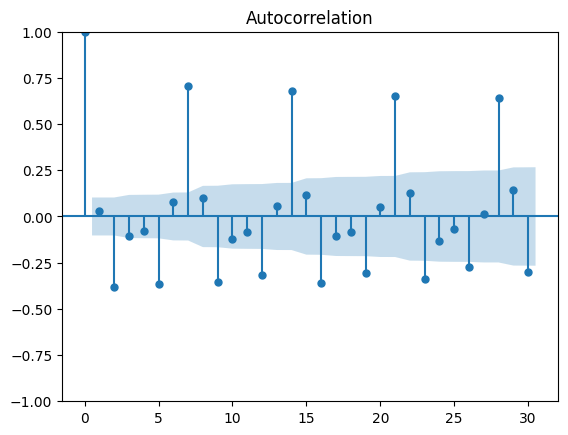

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(df['sd_1'], lags=30)
acf = plot_acf(df['sd_1'], lags=30)

# confidence interval -  values should not be staticlly significant

Use a lag of 4: This would capture the short-term dependency but ignore the long-term dependency.

Use a lag of 24: This would capture both the short-term and long-term dependencies, but it might make your model more complex and slower to train.

Use a seasonal ARIMA model: This type of model can capture both short-term and long-term dependencies. You could use an AR order of 4 and a seasonal order of 12.

In [ ]:
# accessible_columns = ['sd_1']

# new_df = df[accessible_columns].copy()

devider = 7

train = df[:len(df) - devider]
test = df[len(df) - devider:]
train.head()

# train = new_df[:len(df) -7] # only 7 data for test.
# test = new_df[len(df) -7:]
# train.head()



,48,sd_1
date,,
2021-01-02,883,24.0
2021-01-03,646,-237.0
2021-01-04,978,332.0
2021-01-05,1054,76.0
2021-01-06,1109,55.0


In [ ]:
print(test.shape)
print(train.shape)

(7, 2)
(357, 2)


In [ ]:
test.head()


,48,sd_1
date,,
2021-12-25,1529,-692.0
2021-12-26,1902,373.0
2021-12-27,2184,282.0
2021-12-28,2292,108.0
2021-12-29,2402,110.0


In [ ]:
model = AutoReg(train['sd_1'], lags = 15).fit()

print(model.summary())

# model = AutoReg(train['sd_1'], lags = 15).fit()

# print(model.summary())

# lower the time lag p that would be significant.

                            AutoReg Model Results                             
Dep. Variable:                   sd_1   No. Observations:                  357
Model:                    AutoReg(15)   Log Likelihood               -2277.201
Method:               Conditional MLE   S.D. of innovations            188.584
Date:                Tue, 28 May 2024   AIC                           4588.402
Time:                        22:15:02   BIC                           4653.594
Sample:                    01-17-2021   HQIC                          4614.373
                         - 12-24-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6777     10.901      0.888      0.375     -11.689      31.044
sd_1.L1       -0.3156      0.055     -5.756      0.000      -0.423      -0.208
sd_1.L2       -0.2896      0.058     -5.006      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
end_of_train = len(train) # length of train set, start of test set = df[end_of_train]
print(end_of_train)

357


In [ ]:
#prediction_arr = model.predict(start = len(train), end = (len(train) + 7), dynamic= False) # i think we need to give indexes ,  # we are going to predict  7 values

# use forecast steps, - 1

fc_steps = 7

prediction_arr = model.predict(start = end_of_train, end = (end_of_train + fc_steps - 1 ), dynamic= False)

predictions_reverse = prediction_arr.cumsum()

predictions_reverse = predictions_reverse + df[pu_location].iloc[0]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2021-12-25    1432.682745
2021-12-26    1172.607276
2021-12-27     652.139257
2021-12-28     911.306275
2021-12-29    1285.477593
2021-12-30    1202.863583
2021-12-31    1253.081144
Freq: D, dtype: float64
-----
date
2021-12-25    1529
2021-12-26    1902
2021-12-27    2184
2021-12-28    2292
2021-12-29    2402
2021-12-30    2641
2021-12-31    2559
Name: 48, dtype: int64


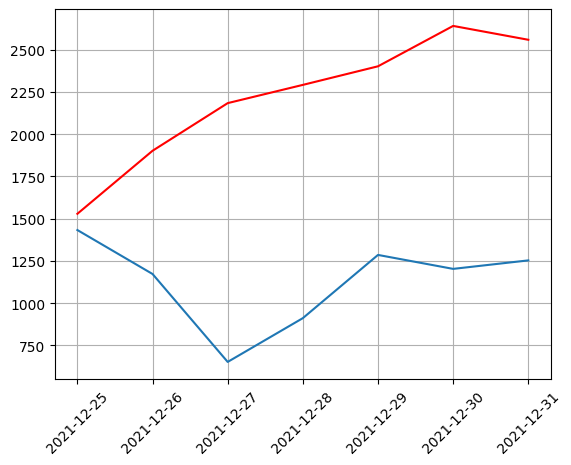

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(prediction_arr)
# plt.plot(test[pu_location], color = 'r')

# print(prediction_arr)

# print("-----")

# print(test)


import matplotlib.pyplot as plt

plt.plot(predictions_reverse)
plt.plot(test[pu_location], color='r' )
plt.grid(True)
plt.xticks(rotation=45)

print(predictions_reverse)

print("-----")

print(test[ pu_location])



In [ ]:
df.shape

(364, 2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain

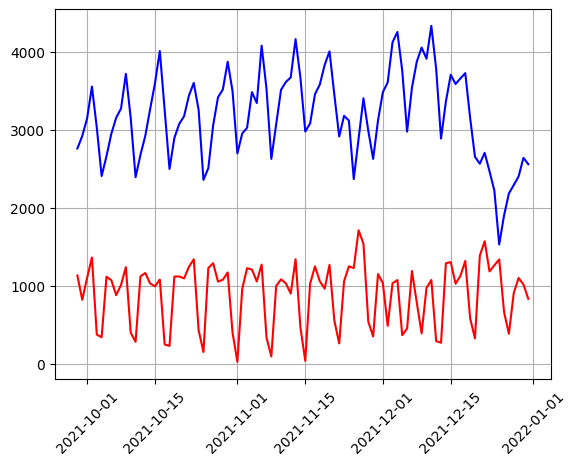

(94,)


In [ ]:
# Initialize an empty list to store the predictions
predictions = []
y = 0

devide_place = 270


# Start the loop from 270 and go up to the end of the DataFrame
for i in range(devide_place, len(df)):
    # Use the data up to the current point to train the model
    train = df[y:i]

    model = AutoReg(train['sd_1'], lags = 15).fit()

    # Predict the next day's value

    len_train = len(train)
    next_day_prediction = model.predict(start=len_train, end=len_train)

    # Reverse the differencing operation and shift the prediction back to the original scale
    next_day_prediction = next_day_prediction.cumsum() + df[pu_location].iloc[0]


    # Add the prediction to the list
    predictions.append(next_day_prediction.values[0])
    y += 1

# Convert the list of predictions to a pandas Series with the correct index
predictions_series = pd.Series(predictions, index=df.index[devide_place:])

# Now you can plot the predictions and the actual values
plt.plot(df[pu_location].iloc[devide_place:], color='blue')
plt.plot(predictions_series, color='red')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
print(predictions_series.shape)